# Application of Newton's Method

In [161]:
%matplotlib notebook
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import numpy as np
import math as m

from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
from matplotlib import ticker
#import cmocean

## Step 1: Function evaluations 
Evaluation of the objective function, its gradient and its Hessian given a specific point $p$, number of segments $n$, segment lenghts $l$ and a set of configuration angles $v$. 

In [113]:
def evalu(n,l,p0,v):
    
    cums = np.cumsum(v)
    f = np.zeros(2)
    g = np.zeros(2)
    ggh = np.zeros((n,2))
    grad_g = np.zeros((n,2))
    H1 = np.zeros((n,n))
    H2 = np.zeros((n,n))
    
    for i in range(n):
        
        c = m.cos(cums[i])
        s = m.sin(cums[i])
        
        f[0] = (l[i]*c)+f[0]
        f[1] = (l[i]*s)+f[1]
        
    
    for i in range(n):
        
            if i == 0 :
                
                for j in range(n):
                    s = m.sin(cums[j])
                    c = m.cos(cums[j])
            
                    ggh[i,0] = l[j]*(-s)+ggh[i,0]
                    ggh[i,1] = l[j]*(c)+ggh[i,1]
                    
                
            else:
                
                for j in range(i,n):
                        
                    s = m.sin(cums[j])
                    c = m.cos(cums[j])
            
                    ggh[i,0] = l[j]*(-s)+ggh[i,0]
                    ggh[i,1] = l[j]*(c)+ggh[i,1]
               
            
     
    
    for i in range(n):
        
            for j in range(n):
        
                if i == 0 and j == 0:
                
                    for k in range(n):
                
                        s = m.sin(cums[k])
                        c = m.cos(cums[k])
            
                        H1[i,0] = l[k]*(-c)+H1[i,0]
                        H2[i,0] = l[k]*(-s)+H2[i,0]
                    
                    
                elif i == n-1:
                    
                        s = m.sin(cums[i])
                        c = m.cos(cums[i])
                        
                        H1[i,j] = l[i]*(-c)
                        H2[i,j] = l[i]*(-s)
                        
                elif j == n-1:
                    
                        s = m.sin(cums[j])
                        c = m.cos(cums[j])
                        
                        H1[i,j] = l[j]*(-c)
                        H2[i,j] = l[j]*(-s)
            
                else:
                    
                    if j == 0:
                    
                        for k in range(i,n):
                    
                            s = m.sin(cums[k])
                            c = m.cos(cums[k])
                    
                            H1[i,j] = l[k]*(-c)+H1[i,j]
                            H2[i,j] = l[k]*(-s)+H2[i,j]
                            
                    else:
                            
                        for k in range(j,n):
                    
                            s = m.sin(cums[k])
                            c = m.cos(cums[k])
                    
                            H1[i,j] = l[k]*(-c)+H1[i,j]
                            H2[i,j] = l[k]*(-s)+H2[i,j]
                            
                    
                    
    g[0] = 0.5*(f[0]-p0[0])**2
    g[1] = 0.5*(f[1]-p0[1])**2
    g = g[0]+g[1]
    
    grad_g = ggh @ (f-p0)
    
    
    trans = ggh.transpose()
    ggh = ggh @ trans
    
    a = f[0]-p0[0] 
    b = f[1]-p0[1]
    
    He1 = ggh + np.multiply(a,H1)
    He2 = ggh + np.multiply(b,H2)
    
    Hessian = He1 + He2
    
    return g,grad_g,He1,He2,H1,H2,Hessian



        
        
        




## Step 2:Line search
The first thing we will do is to find the line search using "Backtracking Armijo".

In [128]:
def BacktrackLineSearch(vk, gk, ggk, pk, ak, c, rho, nmaxls=100):
    
    pkggk = pk @ ggk
   
    g,ggk,He1,He2,H1,H2,Hessian = evalu(n,l,p0,vk+ak*pk)
    
    for i in range (nmaxls):
        if g <= gk + c*ak*pkggk:
            break
        ak *= rho
        g,ggk,He1,He2,H1,H2,Hessian = evalu(n,l,p0,vk+ak*pk)
        
    return ak

Next step is to calculate the search direction for Newton Method which is given by: $p_{k+1}= -(\nabla^2 f(x_{k+1})^{-1} \nabla f(x_{k+1})$.

In [136]:
def searchDirection(vk, ggk, Hessian, epsilon=1e-8):
    
        pk = -np.linalg.solve(Hessian,ggk) # compute the search direction
        if -np.dot(pk,ggk) <= epsilon*np.linalg.norm(ggk)*np.linalg.norm(pk): 
            return -ggk # the directional derivative is ensured to be negative in this direction
        return pk
    


## Step 3:Optimization
Now we need to compute the search direction, perform line search along this direction and then perform the step.

In [137]:
def optimize(n, l, p0, v0, c, rho, tol,nmax):
    
    vk = v0
    listofAng = np.zeros((nmax,n))
    listofAng[0] = v0;
    gk,ggk,He1,He2,H1,H2,Hessian = evalu(n,l,p0,vk)
    pk = None
    ak = 1
    
    
    for k in range(1,nmax):
        
        ak = 1
        pk =  searchDirection(vk, ggk, Hessian, epsilon=1e-8)  #The search direction for Newton method
#         ak = BacktrackLineSearch(vk, gk, ggk, pk, ak, c, rho)
        listofAng[k] = vk + np.multiply(ak, pk)
        vk = listofAng[k]
        gk,ggk,He1,He2,H1,H2,Hessian = evalu(n,l,p0,vk) 
        
        if np.linalg.norm(ggk) < tol:
            break
    
    return listofAng
    

In [138]:
def ROBOT_PLT(n, l, p0, v):
    
    f = np.zeros(2)
    temp0 = np.zeros(n)
    temp = np.zeros(2)    
    
    c = m.cos(v[0])
    s = m.sin(v[0])
    f[0] = (l[0]*c)
    f[1] = (l[0]*s)
    temp0[0] = v[0]
    x_values = (0,f[0])
    y_values = (0,f[1])
    plt.plot(x_values, y_values)
    plt.scatter(f[0],f[1],s=300)


    for i in range(1,n):

            temp[0]=f[0]
            temp[1]=f[1]
            c = m.cos(v[i]+np.sum(temp0))
            s = m.sin(v[i]+np.sum(temp0))

            f[0] = (l[i]*c)+f[0]
            f[1] = (l[i]*s)+f[1]
            temp0[i] = v[i]
         
            x_values = (temp[0],f[0])
            y_values = (temp[1],f[1])
            plt.plot(x_values, y_values)
            plt.scatter(f[0],f[1],s=300)

    plt.scatter(0,0)        
    plt.scatter(p0[0],p0[1])
    plt.show()

    

In [139]:
def OPT_PLT(n, l, p0, v, k):
    
    f = np.zeros(2)
    temp0 = np.zeros(n)
    temp = np.zeros(2) 
    
    c = m.cos(v[0])
    s = m.sin(v[0])
    f[0] = (l[0]*c)
    f[1] = (l[0]*s)
    temp0[0] = v[0]


    for i in range(1,n):

            temp[0]=f[0]
            temp[1]=f[1]
            c = m.cos(v[i]+np.sum(temp0))
            s = m.sin(v[i]+np.sum(temp0))

            f[0] = (l[i]*c)+f[0]
            f[1] = (l[i]*s)+f[1]
            temp0[i] = v[i]
    label = k                
    plt.scatter(f[0],f[1],marker='x',s=50) 
    plt.text(f[0], f[1], k, fontsize=9)
    plt.scatter(p0[0],p0[1],color='black')
    plt.show()

    

In [140]:
def error(n,l,p0,v):
    
    cums = np.cumsum(v)
    f = np.zeros(2)
    
    for i in range(n):
        
        c = m.cos(cums[i])
        s = m.sin(cums[i])
        
        f[0] = (l[i]*c)+f[0]
        f[1] = (l[i]*s)+f[1]
        
    
    h = f-p0
    h = h[0]+h[1]
    h = abs(h)
    
    return h



        
        
        




[[ 0.          1.          1.        ]
 [-0.24750344  1.26576888  1.05229224]
 [-0.3777011   1.37966721  1.02332056]
 [-0.44946566  1.43657053  1.0016921 ]
 [-0.48751784  1.46534765  0.98932915]
 [-0.5071715   1.47987487  0.98276676]
 [-0.51716825  1.48718191  0.9793894 ]
 [-0.52221093  1.49084751  0.97767643]
 [-0.5247436   1.4926835   0.97681384]
 [-0.52601279  1.4936023   0.97638101]
 [-0.5266481   1.49406191  0.97616421]
 [-0.52696594  1.49429177  0.97605572]
 [-0.5271249   1.49440671  0.97600144]
 [-0.5272044   1.49446419  0.9759743 ]
 [-0.52724415  1.49449292  0.97596073]
 [-0.52726402  1.49450729  0.97595394]
 [-0.52727396  1.49451448  0.97595055]
 [-0.52727893  1.49451807  0.97594885]
 [-0.52728141  1.49451987  0.97594801]
 [-0.52728266  1.49452076  0.97594758]
 [-0.52728328  1.49452121  0.97594737]
 [-0.52728359  1.49452144  0.97594726]
 [-0.52728374  1.49452155  0.97594721]
 [-0.52728382  1.49452161  0.97594718]
 [-0.52728386  1.49452163  0.97594717]
 [-0.52728388  1.49452165

<IPython.core.display.Javascript object>


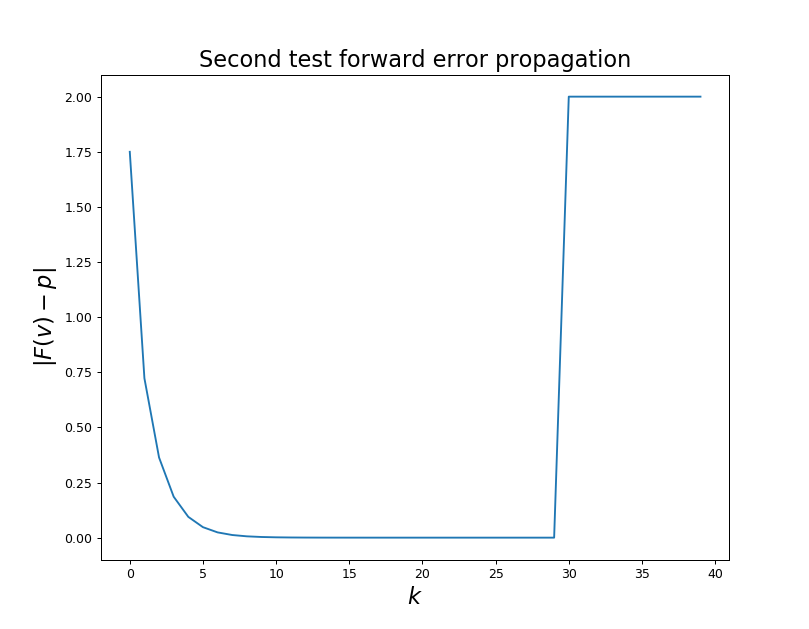

[4.12992746e-01 5.03004900e-01 5.10594802e-01 5.07655807e-01
 5.04439763e-01 5.02376795e-01 5.01228216e-01 5.00624144e-01
 5.00314591e-01 5.00157927e-01 5.00079121e-01 5.00039600e-01
 5.00019810e-01 5.00009907e-01 5.00004954e-01 5.00002477e-01
 5.00001239e-01 5.00000619e-01 5.00000310e-01 5.00000155e-01
 5.00000077e-01 5.00000039e-01 5.00000020e-01 5.00000008e-01
 5.00000000e-01 5.00000005e-01 5.00000010e-01 4.99999922e-01
 5.00000155e-01 6.99141601e+08 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00]


In [172]:
#Input arguments
n = 3  #Number of segments
l = np.array([3, 2, 2])
p0 = np.array([3, 2])



#Initial conditions
#v0 = np.array([1.72, -1.54, -0.9])
v0 = np.array([0,1,1])




#Algorithm parameters
c = 0.01
rho = 0.5
tol = 1e-8
nmax = 40

v_newton = optimize(n, l, p0, v0, c, rho, tol,nmax)




            
###############################################################################################################################""

###   Printing of the iterated angles




print(v_newton)




################################################################################################################################


###          PLOT of the iterations and the robot configurations


# PLOT = plt.figure(figsize=(9,7))
# plt.xlabel('$x$',fontsize=18)
# plt.ylabel('$y$',fontsize=18)
# plt.title('Convergence pattern of the third test',fontsize=18)
# V = np.array([0, 0, 0, 0])


    
# for i in range(nmax):
#     if np.array_equal(v_newton[i],V):
#         print (i)
        
        
        
# for k in range(nmax):
    
#     OPT_PLT(n, l, p0, v_newton[k], k)

# PLOT.savefig("Conv3_N.png")



###############################################################################################################################

###   Robot Plotting

# SOLUTION = np.array([-0.527, 1.495, 0.976])
# plt.figure()
# ROBOT_PLT(n, l, p0, SOLUTION)




###############################################################################################################################


######     Error Evolution Plotting   




PLOT = plt.figure(figsize=(9,7))
plt.xlabel('$k$',fontsize=18)
plt.ylabel('$|F(v)-p|$',fontsize=18)
plt.title('Second test forward error propagation',fontsize=18)
h = np.zeros(nmax)
S = np.array([0, 0, 0, 0])
v_values = np.zeros(nmax)
for i in range(nmax):
    h[i] = error(n,l,p0,v_newton[i])
    v_values[i] = i 
    if np.array_equal(v_newton[i],S):
        h[i] = h[i-1]

plt.plot(v_values, h)
plt.show
PLOT.savefig("fError2_N.png")

###############################################################################################################################


### find the error constant as: err(k+1)=d*err(k) or err(k+1)=d^2*err(k)

d = np.zeros(nmax)
for i in range(nmax):
    if i == nmax-1:
        break
    d[i] = h[i+1]/h[i]
print(d)



